# 网络中的网络
#### 全连接层的问题
- 卷积层需要较少参数：ci * co * k^2
- 但是卷积后的第一个全连接层参数
    - LeNet 16x5x5x120 = 48k
    - AlexNet 256x5x54096 = 26M
    - VGG 512x7x7x4096=102M
   - 容易过拟合，而且占内存，运算贵，矩阵也可能不好算
   
#### NiN块
- 一个卷积层后跟两个全连接层（1*1卷积，此处作用相当于全连接，在于通道做混合，通道间做全连接，目标结果的单个像素等于之前的通道间全连接层）
    - 步幅1，无填充，输出shape跟卷积输出一样
    - 起到全连接的作用
    - 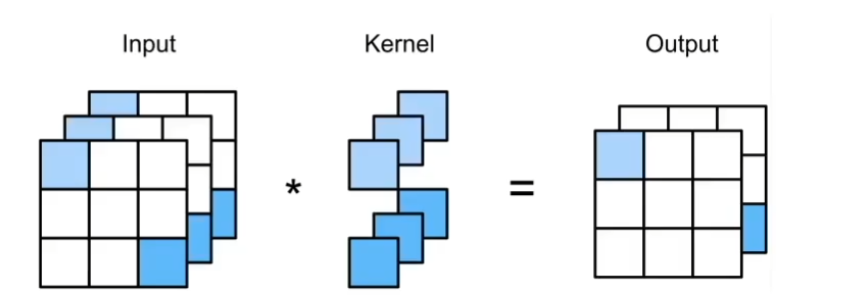
    - 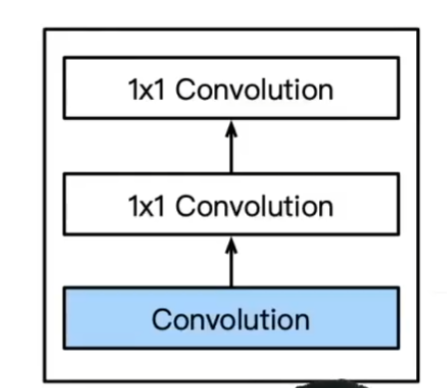
    
#### NiN架构
- 无全连接层
- 交替使用NiN块和步幅为2的最大池化层
    - 逐步减少高宽和增大通道数
- 最后使用全局平均池化层得到输出
    - 其输入通道数是类别
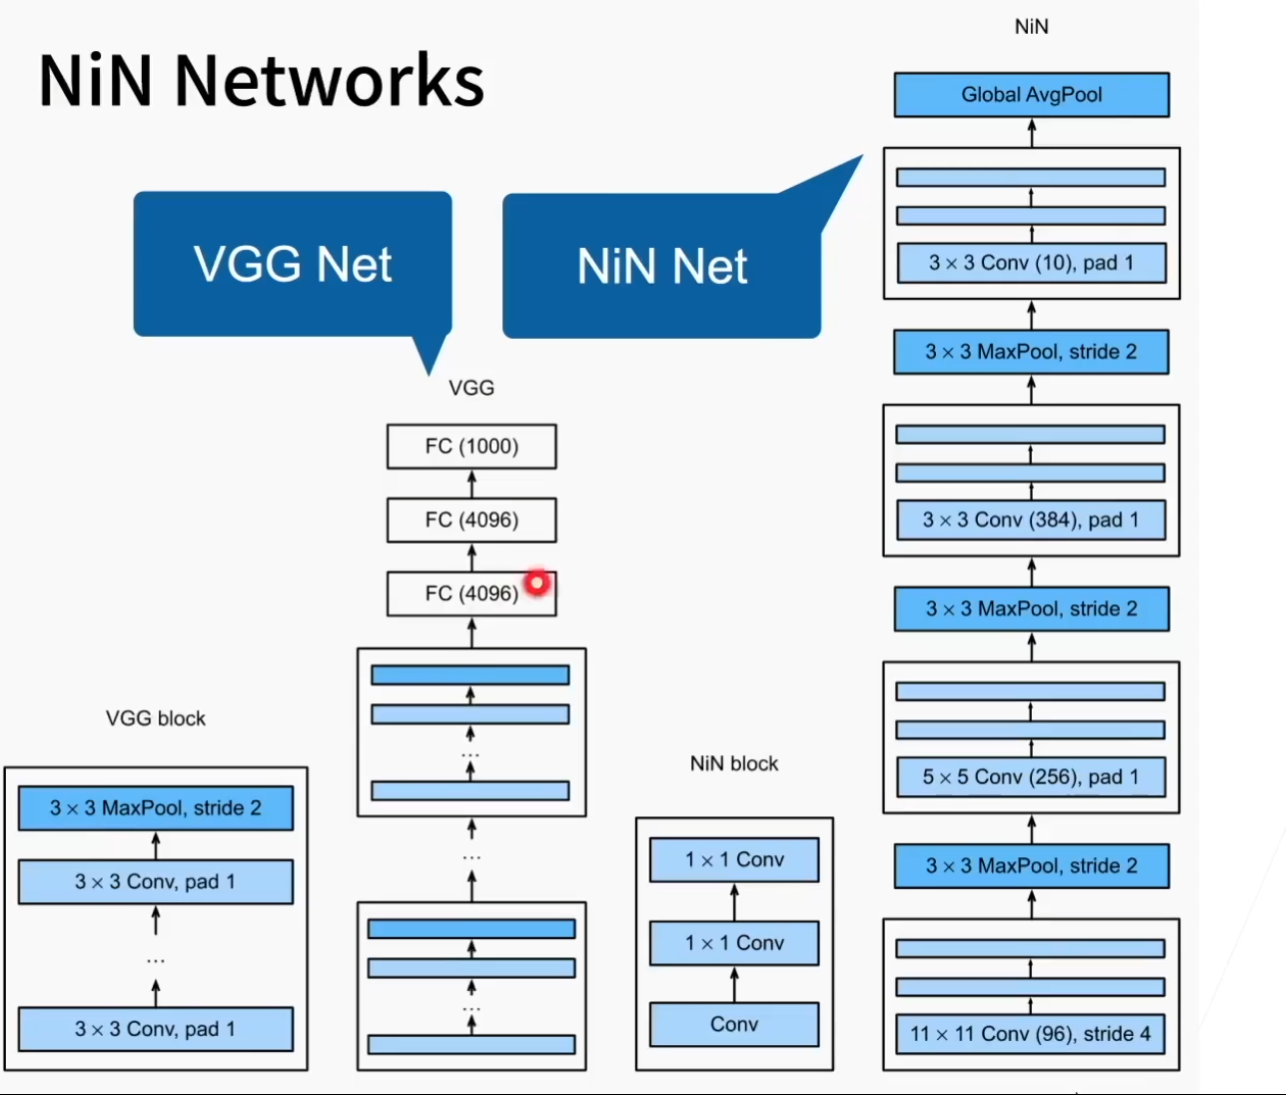

#### 总结
- NiN块使用卷积层加两个1x1卷积层
 - 后者对每个像素增加了非线性性
- NiN使用全局平均池化层来替代VGG和AlexNet中的全连接层
 - 不容易过拟合，更少的参数

# 代码

In [ ]:
## 网络中的网络NiN 
#### NiN块
import torch
from torch import nn
from d2l import torch as d2l

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU()
    )

In [ ]:
## NiN模型，基于AlexNet
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2), nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1), # 此处fashion-mnist 类别10，可以替换成自己的类别
    nn.AdaptiveAvgPool2d((1, 1)),  # 全局的平均池化层
    nn.Flatten() 
)

In [ ]:
# 查看每个块的输出shape
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [ ]:
# 训练模型
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device='cuda:0')

# QA
#### 一个超级宽的单隐藏层难以训练是因为显存不够大吗？
- 不是显存的问题，而是非常容易过拟合，效果很差
#### 为什么6G显存 vgg跑起来刚好125的batch size 占用4G 
- 一般来说显存占用可能有显示器，模型参数大小（此时算上梯度的话就是double）然后剩下的显存几乎就是跟batch size成线性关系了
#### 写好的模型如何部署呢？cpp全部重写，然后部署torch script?tflite? torch serve？
- 如果一定需要CPP，pytorch 可以用torch script,但是取决你的模型复杂度，如果太复杂可能难以迁移过去
- tf lite，mxnet也有框架，或者直接用第三方的如onnx
- torch serve是不同于上面的，serving一般情况是多个GPU、服务器资源，多模型来调度使用，类似html的pages，给个输入返回输出这种，包括模型本身的调度，优先级等；
很多框架都有，如torch serve,tf也有，或者nvidia 的triton也好用，找一个用就行了；为了效率可以考虑python直接for loop也行
#### NiN的分类为什么不做softmax？
- 分类是做的，不是最后的pooling层取代了softmax，而是没放在卷积中，放在了train_ch6中的loss计算中去了，是有的
- 交叉熵默认和softmax绑定在一起用的
#### NiN的全局池化层是不是很关键？
- 是的，一般把卷积的feature map不管多大直接压成1x1，没有参数需要学习，极大降低了模型复杂度，效果很好，提升泛化性
- 缺点在于收敛变慢，一般加入后会导致可能多扫1-2遍数据，但是多训练时间没关系，精度好才是关键 
#### 为什么NiN添加2个1x1而不是1个或者3个？
- 盲猜应该原来作者试过，但是效果2个最好，可以去自己试试
#### 如果理解2个1x1卷积对像素增加了非线性性？
- 1x1卷积相当于对单个像素做了通道间的全连接了，而且卷积之后会跟ReLU增加非线性，不管1个还是2个1x1都增加了非线性，相当于做了2层的全连接增再分别ReLU
#### 同样都是V100？为什么他的快？
- 差别在于PCIE和SXM2接口，计算性能查10%但是内部带宽差10倍

# 含并行连接网络GoogleNet